### Bibliotecas necessárias


In [1397]:
# Implementation of matplotlib function
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import time as t



### Abrir imagem

Altura da imagem: 435 | Largura da imagem: 474


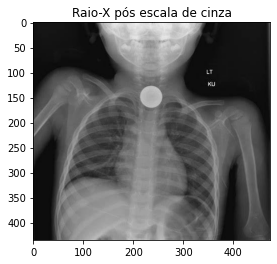

In [1398]:
ddepth = cv2.CV_16UC1
scale = 1
delta = 0
alpha = 2
beta = 50

def loadImage(image: str):

    image = cv2.imread(image, cv2.IMREAD_COLOR) ## CHAVE ALTO CONSTRASTE
    #image = cv2.imread("image2.jpg", cv2.IMREAD_COLOR) ## CIRCULO - MOEDA
    #image = cv2.imread("image6.jpg", cv2.IMREAD_COLOR) ## Linha fina - sobel
    #image = cv2.imread("image7.jfif", cv2.IMREAD_COLOR) ##CIRCULAR
    #image = cv2.imread("image10.jpg", cv2.IMREAD_COLOR) ## Linha - sobel
    #image = cv2.imread("image11.png", cv2.IMREAD_COLOR) ## Linha - sobel
    #image = cv2.imread("image12.jpeg", cv2.IMREAD_COLOR) ## Linha - sobel
    (height, width) = image.shape[:2]
    print("Altura da imagem: {} | Largura da imagem: {}".format(height, width))
    return image
loadedImage = loadImage("image2.jpg")

plt.imshow(loadedImage)
plt.title("Raio-X pós escala de cinza")
plt.show()

In [1399]:
def teste():
    print("TESTE")

### Conversão para escala de cinza

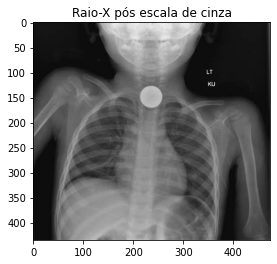

In [1400]:

def toGrayScale(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Converte para escala de cinza
    return grayScale

grayImage = toGrayScale(loadedImage)
plt.imshow(grayImage)
plt.title("Raio-X pós escala de cinza")
plt.show()


### Aplicação de um filtro gaussiano

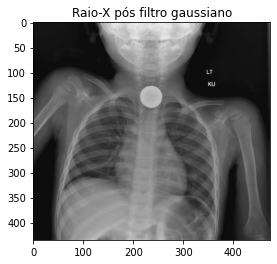

In [1401]:
#imageGauss = cv2.GaussianBlur(grayImage, (3, 3), 0)
def gaussFilter(image):
    gaussFilteredImage = cv2.medianBlur(image, 1)
    return gaussFilteredImage
    
imageGauss = gaussFilter(grayImage)
plt.imshow(imageGauss)
plt.title('Raio-X pós filtro gaussiano')
plt.show()

### Ajuste de brilho e contraste
- Implementação de uma escala de ajuste para brilho e contraste, intervalo [-127, 127] semelhante ao GIMP

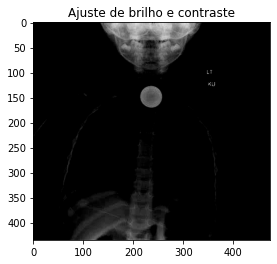

In [1402]:
def gimpBrightContrastControl(image, brightness: float, contrast: float):

    brightness = brightness # brilho inicial 100
    contrast = contrast # contraste inicial 50
    shadow = 0
    highlight = 255 + brightness

    alpha_b = (highlight - shadow)/255
    gamma_b = shadow
    brightContrastProcImage = cv2.addWeighted(image, alpha_b, image, 0, gamma_b)
    f = 131*(contrast + 127)/(127*(131-contrast)) 
    alpha_c = f
    gamma_c = 127*(1-f)
    brightContrastProcImage = cv2.addWeighted(brightContrastProcImage, alpha_c, brightContrastProcImage, 0, gamma_c)

    return brightContrastProcImage

adjustedContrastBrightImg = gimpBrightContrastControl(imageGauss, -127, 50) #-100, 50
plt.imshow(adjustedContrastBrightImg)
plt.title('Ajuste de brilho e contraste')
plt.show()

### Gradiente X - Sobel

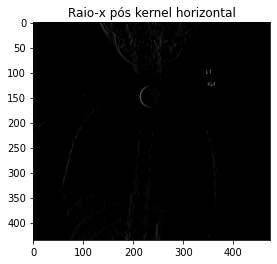

In [1403]:
def applySobelGradientX(image):   
    grad_x = cv2.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    return grad_x

xSobelGradient = applySobelGradientX(adjustedContrastBrightImg)
plt.imshow(xSobelGradient)
plt.title("Raio-x pós kernel horizontal")
plt.show()

### Gradiente Y - Sobel

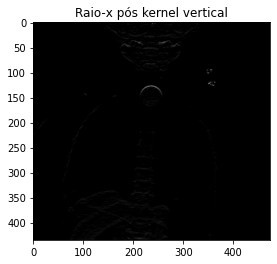

In [1404]:

def applySobelGradientY(image):   
    grad_y = cv2.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    return grad_y

ySobelGradient = applySobelGradientY(adjustedContrastBrightImg)
plt.imshow(ySobelGradient)
plt.title("Raio-x pós kernel vertical")
plt.show()

### Conjugação dos resultados dos gradientes

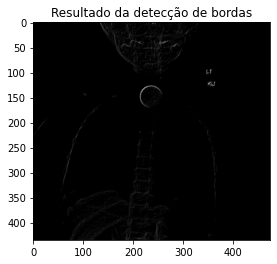

In [1405]:
def mergeGradients(grad_x, grad_y):
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    imgSobel = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return imgSobel

imgSobel = mergeGradients(xSobelGradient, ySobelGradient)
plt.imshow(imgSobel)
plt.title("Resultado da detecção de bordas")
plt.show()

Altura da imagem sobel: 435 | Largura da imagem sobel: 474


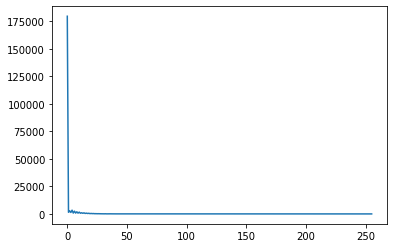

In [1406]:
(height, width) = imgSobel.shape[:2]
print("Altura da imagem sobel: {} | Largura da imagem sobel: {}".format(height, width))

histSize = 256
histRange = (0, 256) # O limite superior é exclusivo
accumulate = False 
hist = cv2.calcHist([imgSobel], [0], None, [histSize], histRange, accumulate=accumulate)

total = 0

#print(hist[255][0])
#print(hist)
#for i in range(0, histSize):
#    if(hist[i][0] != 0):
#        print("{} - {}".format(i, hist[i][0]))

plt.plot(hist)


121.0


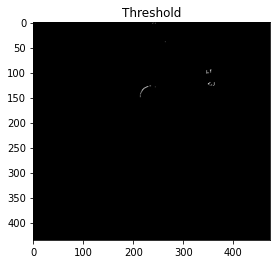

In [1407]:
def applyThreshold(image, minThres: float, maxThres: float):
    ret, imgThreshold = cv2.threshold(image, minThres, maxThres, cv2.THRESH_BINARY) ##CANNY
    print(ret)
    return imgThreshold

imageThreshold = applyThreshold(imgSobel, 121, 255) #121, 255
plt.imshow(imageThreshold)
plt.title("Threshold")
plt.show()


### Detecção de linhas

In [1408]:
def applyHoughTransformLines(image, threshold, minLineLength, maxLineGap):
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=threshold, minLineLength=minLineLength,maxLineGap = maxLineGap) ## COM THRESHOLD
    return lines

detectedLines = applyHoughTransformLines(imageThreshold, 30, 3, 1) #30, 3, 1

try:
    if(detectedLines.any != None):
        print(len(detectedLines))

        for line in detectedLines:
            x1, y1, x2, y2 = line[0]
            #print(line[0])
            cv2.line(loadedImage, (x1, y1), (x2, y2), (255,0,0),4)
        plt.imshow(loadedImage)
        plt.title("Transformada de Hough")
        plt.show()
except:
    print("Nenhuma linha foi identificada nesta imagem")

Nenhuma linha foi identificada nesta imagem


### Detecção de círculos

1


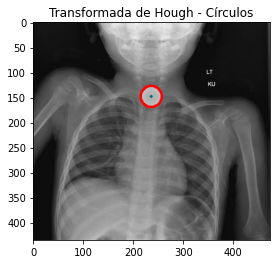

In [1409]:
def applyHoughTransformCircles(image, minRadius, maxRadius):
    rows = image.shape[0]
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, rows / 8,
                                param1=170, param2=30,
                                minRadius=minRadius, maxRadius=maxRadius)
    return circles

detectedCircles = applyHoughTransformCircles(adjustedContrastBrightImg, 0, 70) #0,70
try:
    print(len(detectedCircles[0]))
    if detectedCircles is not None:
            circles = np.uint16(np.around(detectedCircles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                # circle center
                cv2.circle(loadedImage, center, 1, (0, 100, 100), 3)
                # circle outline
                radius = i[2]
                cv2.circle(loadedImage, center, radius, (255, 0, 0), 3)
except:
    print("Nenhum círculo foi encontrado")



plt.imshow(loadedImage)
plt.title("Transformada de Hough - Círculos")
plt.show()
